# UCDPA Data Analytics Essentials Project

Analysis of Dataset 'Motor Vehicle Collisions - Crashes' from the City of New York

Author: Hauke Laing

Dataset Source: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

API Reference: https://dev.socrata.com/foundry/data.cityofnewyork.us/h9gi-nx95

In [1]:
# import required libraries
import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data Collection

We first define some helper functions for reading the data from the API

In [2]:
def read_api_chunk(api, limit=1000, offset=0):
    """read a single chunk from the api"""
    return pd.read_json(f"{api}?${limit=}&${offset=}")


def read_api(api, total_size, chunk_size=1000):
    """read given number of lines from api, applying the chunk_size along the way"""
    # use https://docs.python.org/3/reference/expressions.html#yield-expressions
    chunk_generator = (
        # define chunks; the last chunk might be smaller than chunk_size
        read_api_chunk(api, limit=min(chunk_size, total_size - x), offset=x)
        for x in range(0, total_size, chunk_size)
    )
    # in the generator expressions, the chunks are not yet read and stored in memory
    # the outer paranthesis are synctactilly required for generator expressions; they
    # are not included simply in order to permit the multiline definition

    # pd.concat can handle generator expressions. According to the api reference, the objs argument
    # accepts a sequence of DataFrame objects. This indicates that any iterable that yields DataFrame
    # objects will be accepted, which is what chunk_generator provides.
    return pd.concat(chunk_generator)

def read_api_2(api, size, n_chunks):
    """read given number of lines from api by splitting the request into n_chunks chunks"""
    grid = np.unique(np.linspace(0, size, num=n_chunks).astype('int'))
    steps = np.diff(grid)
    chunk_generator = (
        read_api_chunk(api, limit=steps[i], offset=grid[i])
        for i in range(len(steps))
    )
    return pd.concat(chunk_generator)

Set the input parameters

In [3]:
api = "https://data.cityofnewyork.us/resource/h9gi-nx95.json"
n = 600e3
n_chunks = 6
seed = 8

Read the data

In [4]:
# read data
data_raw = read_api_2(api, size=n, n_chunks=n_chunks)

Check the size of the data to confirm that the expected number of lines has been downloaded

In [5]:
data_raw.shape

(600000, 29)

## Data Preparation 

First we clean the data and carry out some plausibility checks

In [6]:
# return dtypes to check data structure
data_raw.dtypes

crash_date                               object
crash_time                       datetime64[ns]
on_street_name                           object
off_street_name                          object
number_of_persons_injured               float64
number_of_persons_killed                float64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
contributing_factor_vehicle_1            object
contributing_factor_vehicle_2            object
collision_id                              int64
vehicle_type_code1                       object
vehicle_type_code2                       object
borough                                  object
zip_code                                float64
latitude                                float64
longitude                               

In [8]:
# initial cleaning of data
# we make a copy of the raw data first to ensure the original state remains available
data_clean = data_raw

# fix inconsistent column names
data_clean.rename(
    columns={
        "vehicle_type_code1": "vehicle_type_code_1",
        "vehicle_type_code2": "vehicle_type_code_2",
    },
    inplace=True,
)

# order column names
data_clean = data_clean.reindex(sorted(data_clean.columns), axis=1)

# store text columns as string
text_cols = [col for col in data_clean if re.search("(street|contributing_factor)", col)]
data_clean[text_cols] = data_clean[text_cols].astype("string")

# return dtypes to confirm new type
data_clean.dtypes

borough                                  object
collision_id                              int64
contributing_factor_vehicle_1    string[python]
contributing_factor_vehicle_2    string[python]
contributing_factor_vehicle_3    string[python]
contributing_factor_vehicle_4    string[python]
contributing_factor_vehicle_5    string[python]
crash_date                               object
crash_time                       datetime64[ns]
cross_street_name                string[python]
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured               float64
number_of_persons_killed                

In [9]:
# set index
data_clean.set_index(keys="collision_id", drop=False, inplace=True)

# remove duplicate collision ids and ensure the first one is being kept
duplicate_collision_ids = data_clean.index.duplicated(keep='first')
data_clean = data_clean[~duplicate_collision_ids]
print(f"{sum(duplicate_collision_ids)} duplicate collision ids have been removed.")

22 duplicate collision ids have been removed.


We carry out a plausibility check on the number of injured persons

In [10]:
# find implausible combinations
invalid_number_of_persons_injured = (
    data_clean[
        [
            "number_of_pedestrians_injured",
            "number_of_cyclist_injured",
            "number_of_motorist_injured",
        ]
    ].sum(axis=1)
    > data_clean["number_of_persons_injured"]
)

# drop invalid rows
data_clean = data_clean[~invalid_number_of_persons_injured]
print(f"{sum(invalid_number_of_persons_injured)} collisions with invalid number of injured persons removed.")

8 collisions with invalid number of injured persons removed.


In [11]:
# remove nas from the number of persons injured
data_clean = data_clean[~data_clean["number_of_persons_injured"].isna()]

### Explore

Investigate the target column representing the number of injured persons in a collision. 

In [12]:
# explore number of injured persons
occ = data_clean["number_of_persons_injured"].value_counts()
print(occ)

number_of_persons_injured
0.0     437833
1.0     125871
2.0      24052
3.0       7674
4.0       2796
5.0       1012
6.0        388
7.0        178
8.0         72
9.0         32
10.0        22
11.0         9
12.0         8
15.0         5
13.0         4
17.0         3
14.0         3
18.0         2
20.0         2
40.0         1
16.0         1
Name: count, dtype: int64


In [13]:
# print relative occurence
print(occ / sum(occ))

number_of_persons_injured
0.0     0.729761
1.0     0.209796
2.0     0.040089
3.0     0.012791
4.0     0.004660
5.0     0.001687
6.0     0.000647
7.0     0.000297
8.0     0.000120
9.0     0.000053
10.0    0.000037
11.0    0.000015
12.0    0.000013
15.0    0.000008
13.0    0.000007
17.0    0.000005
14.0    0.000005
18.0    0.000003
20.0    0.000003
40.0    0.000002
16.0    0.000002
Name: count, dtype: float64


In [14]:
# print statistic
print(f"In about {(100 * (1 - occ/sum(occ)))[0]:.1f} out of 100 collisions at least one person is injured.")

In about 27.0 out of 100 collisions at least one person is injured.


The ration of collisions where no cyclist was injured is very high. This ratio can also be seen as the accuracy of an algorithm that predicts that no cyclist ever gets injured in a collision. This will be an important benchmark for machine learning algorithms - they should certainly be better than that if they are of any use. 

### Feature Engineering

The dataset has 5 columns to cover up to 5 vehicles involved in a collision regarding. We want to transform the data such that all vehicles are covered in one column by adding a second index. 

In [15]:
# transform the dataframe "wide to long"
data_long = pd.wide_to_long(
    data_clean,
    stubnames=["vehicle_type_code_", "contributing_factor_vehicle_"],
    i="collision_id",
    j="vehicle_no",
)

# clean up names
data_long.rename(
    columns={
        "vehicle_type_code_": "vehicle_type_code",
        "contributing_factor_vehicle_": "contributing_factor_vehicle",
    },
    inplace=True,
)

# reindex
data_long = data_long.reindex(sorted(data_long.columns), axis=1)


# keep rows for vehicle no. > 1 only if relevant information pertaining to the vehicle is present; the row is redundant otherwise
_cnd1 = (
    data_long[["vehicle_type_code", "contributing_factor_vehicle"]]
    .notnull()
    .any(axis=1)
)
_cnd2 = data_long.index.get_level_values(level=1) == 1
_cnd = _cnd1 | _cnd2
data_long = data_long.loc[_cnd, :]

# export long data
# data_long.to_csv("data_long.csv")

# explore the column 'contributing_factor_vehicle'
data_long["contributing_factor_vehicle"].value_counts()

contributing_factor_vehicle
Unspecified                                          612504
Driver Inattention/Distraction                       183571
Following Too Closely                                 56598
Failure to Yield Right-of-Way                         45707
Passing or Lane Usage Improper                        31201
Passing Too Closely                                   27173
Other Vehicular                                       25647
Backing Unsafely                                      25454
Unsafe Lane Changing                                  18866
Unsafe Speed                                          16169
Traffic Control Disregarded                           14734
Turning Improperly                                    14427
Driver Inexperience                                   11615
Reaction to Uninvolved Vehicle                        10667
Alcohol Involvement                                    7951
View Obstructed/Limited                                6252
Pavement Sli

The column 'contributing_factor_vehicle' contains a text comment. To prepare the column for machine learning algorithms, we want to categorize it and later create dummies. 

In [16]:
# establish a code representing a contributing factor and a corresponding mapping
contributing_factor = (
    data_long["contributing_factor_vehicle"]
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
    .to_frame(name="contributing_factor")
)

# define a function to be applied to a pd series further on
def get_first_chars(input):
    """retrieve first character of each word in a string of words"""
    return "".join(item[0].upper() for item in re.findall("\w+", input))

# create initial code
contributing_factor["cf"] = contributing_factor["contributing_factor"].apply(
    get_first_chars
)

# if code is not unique, add counting index
contributing_factor["n"] = contributing_factor.groupby(["cf"]).cumcount()
_k = contributing_factor["n"] > 0
contributing_factor.loc[_k, "cf"] = (
    contributing_factor.loc[_k, "cf"] + 
    contributing_factor.loc[_k, "n"].astype("string")
    )
contributing_factor.set_index("contributing_factor", inplace=True)

# create mapping to convert contributing factor
# also export the mapping for reference
contributing_factor.to_csv("output/contributing_factor.csv")
contributing_factor_cols = "cf." + contributing_factor["cf"]
contributing_factor_mapping = pd.Series(contributing_factor["cf"]).to_dict()

# apply mapping
data_long["cf"] = data_long["contributing_factor_vehicle"].replace(contributing_factor_mapping)
data_long["cf"].value_counts()

cf
U         612504
DID       183571
FTC        56598
FTYROW     45707
POLUI      31201
PTC        27173
OV         25647
BU         25454
ULC        18866
US         16169
TCD        14734
TI         14427
DI         11615
RTUV       10667
AI          7951
VOL         6252
PS          6216
PBOPEC      5371
ADRR        4030
OV1         3834
BD          2412
FA          2125
PD          1940
OD          1462
OCD         1458
SF          1140
G           1116
TFI          922
FTKR         864
LC           842
I            834
PD1          762
FD           683
AA           592
DRV          578
DI1          461
LMII         407
TCDINW       372
AD           371
CPHH         264
PD2          218
TW           108
OLD           88
THD           84
OED           77
HD            70
VV            69
UOBND         69
PM            66
EOD           64
CPHF          33
SDI           29
T             22
LUH           19
WI            12
Name: count, dtype: Int64

Similar to the column 'contributing factor' is the column 'vehicle type'. We want to prepare it as categorical data.

In [17]:
# align formatting of text
data_long["vehicle_type"] = (
    data_long["vehicle_type_code"]
    .str.replace(pat=r"\W+", repl="_", regex=True)
    .str.lower()
)

# explore column values
data_long["vehicle_type"].value_counts()

vehicle_type
sedan                                  495742
station_wagon_sport_utility_vehicle    394525
taxi                                    39140
pick_up_truck                           30928
box_truck                               25246
                                        ...  
dumpt                                       1
light                                       1
army                                        1
fdny_lader                                  1
van_ford                                    1
Name: count, Length: 1126, dtype: int64

In [18]:
# reduce to top 50 most frequent types of cars. 
top = 50
vehicle_top_cats = data_long["vehicle_type"].value_counts().head(top - 1).index
data_long["vt"] = data_long["vehicle_type"]

# rename other values to type 'other'
data_long.loc[
    ~data_long["vehicle_type"].isin(vehicle_top_cats)
    & ~data_long["vehicle_type"].isna(),
    ["vt"],
] = "other"

# store as category
data_long["vt"] = data_long["vt"].astype("category")

# explore new values
data_long["vt"].value_counts()

vt
sedan                                  495742
station_wagon_sport_utility_vehicle    394525
taxi                                    39140
pick_up_truck                           30928
box_truck                               25246
bike                                    22877
bus                                     18048
tractor_truck_diesel                     9479
van                                      7450
motorcycle                               7344
e_bike                                   5420
other                                    5177
ambulance                                4145
dump                                     3727
e_scooter                                3567
convertible                              2836
flat_bed                                 2455
garbage_or_refuse                        2130
pk                                       2033
moped                                    1958
carry_all                                1585
tractor_truck_gasoline         

Now we are ready to create dummies from the 'contributing factor' and 'vehicle type' columns. The processed versions of these columns have been stored as 'cf' and 'vt'.

In [19]:
# get dummies
dummies_long = pd.get_dummies(
    data_long, prefix=["vt", "cf"], columns=["vt", "cf"], prefix_sep="."
)

# select dummy columns
dummies = dummies_long.filter(regex=r"^(vt|cf)\.").groupby(level=0).max()

# deduce and store number of vehicles involved
dummies["n_vehicles"] = dummies.filter(regex=r"^cf\.").sum(axis=1) 

# after using contributing factor to deduce the number of involved vehicles we drop the dummie for the value 'Unspecified', as it can now be regarded as NaN
dummies = dummies.drop(columns=["cf." + contributing_factor_mapping["Unspecified"]])

# explore dataframe with dummies
dummies.head()

,vt.3_door,vt.4_dr_sedan,vt.ambul,vt.ambulance,vt.armored_truck,vt.beverage_truck,vt.bike,vt.box_truck,vt.bus,vt.carry_all,...,cf.THD,cf.TI,cf.TW,cf.ULC,cf.UOBND,cf.US,cf.VOL,cf.VV,cf.WI,n_vehicles
collision_id,,,,,,,,,,,,,,,,,,,,,
3456194,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3460534,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3511951,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,2
3528065,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3618395,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


After creating dummies, it is useful to create a copy of the data with the source columns for the dummies removed.

In [20]:
# drop obsolete columns
data_clean.drop(
    columns=[
        "vehicle_type_code_1",
        "vehicle_type_code_2",
        "vehicle_type_code_3",
        "vehicle_type_code_4",
        "vehicle_type_code_5",
        "contributing_factor_vehicle_1",
        "contributing_factor_vehicle_2",
        "contributing_factor_vehicle_3",
        "contributing_factor_vehicle_4",
        "contributing_factor_vehicle_5"
    ],
    inplace=True
)

We are ready to create the the clean dataset named 'collisions'

In [21]:
# as the collision id serves as index for both dataframes, they can easily be joined. 
collisions = data_clean.join(dummies)
# collisions.to_csv("output/collisions.csv")

## Algorithm Setup

In [22]:
# import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# import model selection utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold

First we need to split the data. We will work with a KFold object using 5 folds, while holding out an extra test set for final validation. This makes 6 folds in total, therefore we chose a test size of 1/6 to ensure that all 6 sets are about the same size.

In [23]:
# split data
X = collisions.filter(regex=r"^(vt|cf)\.", axis=1)
y = collisions["number_of_persons_injured"]

# execute split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

### Estimator Comparison

#### Initial Comparison

In [24]:
# import models
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier

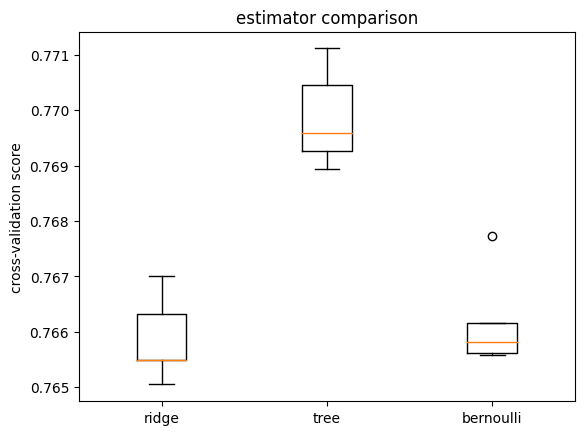

In [25]:
# determine cross-validation score for a list of models
models_initial = {
    "ridge": RidgeClassifier(),
    "tree": DecisionTreeClassifier(random_state=seed),
    'bernoulli': BernoulliNB(binarize=None)
}

# define KFold of data
kf = KFold(random_state=seed, shuffle=True)

# compute cross-validation scores
cross_scores_initial = [cross_val_score(clf, X_train, y_train, cv=kf) for clf in models_initial.values()]

# plot results
plt.boxplot(cross_scores_initial, labels=models_initial.keys())
plt.title("estimator comparison")
plt.ylabel("cross-validation score")
plt.show()

The decision tree shows the best performance. However, trees have a high risk of overfitting. Therefore, we will also compare the scores for the prediction on the test set. To do this we will build a dataframe to compare cross-validation and test scores. 

In [26]:
# loop through models and perform fit to training data
for clf in models_initial.values():
    clf.fit(X_train, y_train)

# determine score for test set
scores_initial = [clf.score(X_test, y_test) for clf in models_initial.values()]

# determine score for training set
scores_initial_train = [clf.score(X_train, y_train) for clf in models_initial.values()]
# set up dataframe
df_scores_initial = pd.DataFrame(
    [scores_initial, scores_initial_train, np.array(cross_scores_initial).mean(axis=1)]
).transpose()

# initialise columns
df_scores_initial.columns = ["test_score", "training_score", "cv_mean_score"]

# use estimator names as index
df_scores_initial.index = models_initial.keys()

# deviation between cross-validation mean score and test score in percentage points
df_scores_initial["cv_vs_test"] = (
    df_scores_initial["cv_mean_score"] - df_scores_initial["test_score"]
) * 100

# deviation of training score vs test score in percentage points
df_scores_initial["train_vs_test"] = (
    df_scores_initial["training_score"] - df_scores_initial["test_score"]
) * 100

# export scores
df_scores_initial.to_csv("output/scores_initial.csv")

# show table
df_scores_initial

,test_score,training_score,cv_mean_score,cv_vs_test,train_vs_test
ridge,0.763628,0.765893,0.765873,0.224518,0.226518
tree,0.768198,0.777778,0.769872,0.167317,0.957959
bernoulli,0.763988,0.766157,0.766179,0.219118,0.216917


#### Tree-based Models

In [27]:
# import tree-based models from ensemble module
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [28]:
# define dictionary of chosen tree-based models
# set max_depth of 7 to reduce calculation time
models_tree = {
    "tree": DecisionTreeClassifier(max_depth=7, random_state=seed),
    'forest': RandomForestClassifier(max_depth=7, random_state=seed),
    'bagging': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=7), random_state=seed)
}

# determine cross-validation score for a list of tree-based models
scores_tree = [cross_val_score(clf, X_train, y_train, cv=kf) for clf in models_tree.values()]

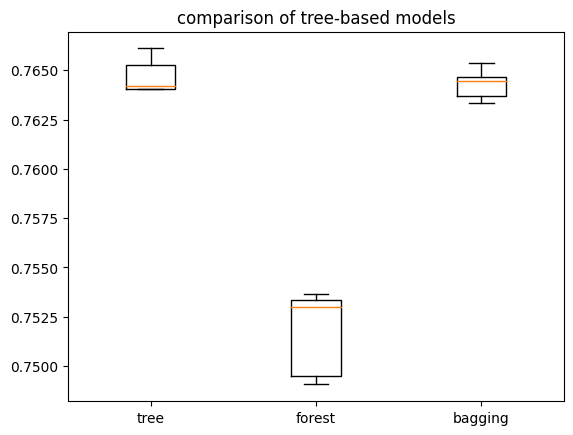

In [29]:
# plot results
plt.boxplot(scores_tree, labels=models_tree.keys())
plt.title("comparison of tree-based models")
plt.show()

A decision tree is still best, but not bagging is almost as good. We perform a direct prediction on the isolated test set to see if the decision tree is still ahead

In [30]:
# perform a prediction with a decision tree on the actual test set
tree = DecisionTreeClassifier(random_state=seed)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
acc_score_tree = accuracy_score(y_test, y_pred_tree)

In [31]:
# perform the same prediction with a bagging classifier
bag = BaggingClassifier(random_state=seed)
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
acc_score_bag = accuracy_score(y_test, y_pred_bag)

In [32]:
# compare the outcome
print(f"The decision tree achieves a score of {acc_score_tree:.5f} on the test set")
print(f"The bagging classifier achieves a score of {acc_score_bag:.5f} on the test set")
# a decision tree is still better!

The decision tree achieves a score of 0.76820 on the test set
The bagging classifier achieves a score of 0.76758 on the test set


### Focus on Decision Tree

In [33]:
# import utility to display confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

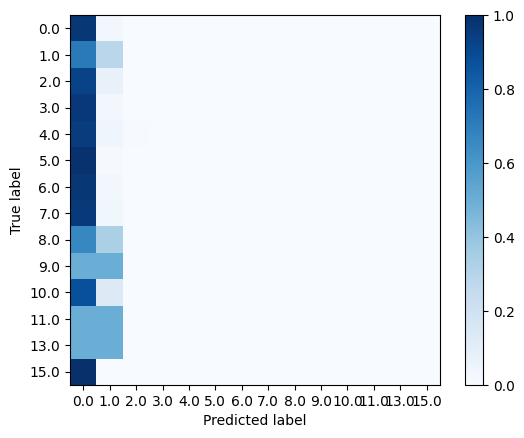

In [34]:
# plot confusion matrix
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, normalize='true', include_values=False, cmap=plt.cm.Blues)
plt.show()

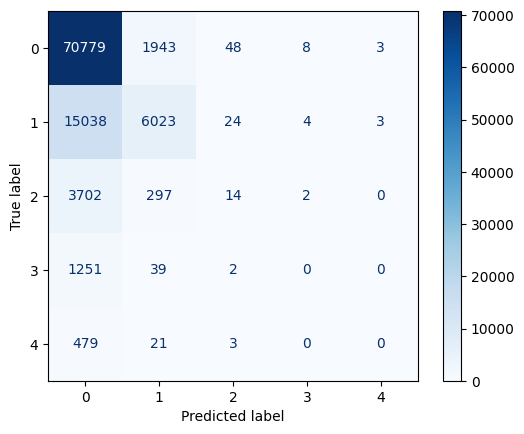

In [35]:
# focus on smaller set of classes
cm = confusion_matrix(y_test, y_pred_tree)
cm_small = cm[0:5, 0:5]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_small)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Boosting

In [36]:
# initialise an AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
dt = DecisionTreeClassifier(max_depth=2, random_state=seed)
ada = AdaBoostClassifier(estimator=dt, n_estimators=100)

In [37]:
# perform cross-validation
ada_cv = cross_val_score(ada, X_train, y_train, cv=kf)

In [38]:
# append results to previous results for tree-based models
models_boost = models_tree
scores_boost = scores_tree
models_tree["ada"] = ada
scores_boost.append(ada_cv)

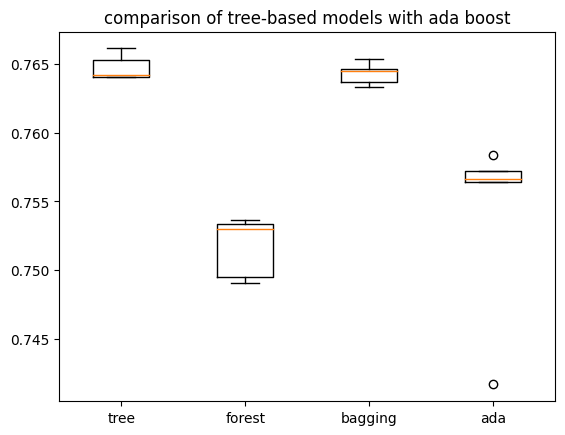

In [39]:
# plot results
plt.boxplot(scores_boost, labels=models_boost.keys())
plt.title("comparison of tree-based models with ada boost")
plt.show()

### Hyper-Parameter Boosting

#### Decision Tree Classifier

In [40]:
# we first have a closer look at the Ridge Classifier
from sklearn.model_selection import GridSearchCV

In [41]:
# initialise grid search
tree_params = {
        # "max_depth": np.arange(5, 10),
        # "max_depth": [2, 3, 4],
        "min_samples_leaf": np.arange(1, 51, 5)
        }
tree_cv = GridSearchCV(DecisionTreeClassifier(random_state=seed), tree_params, cv=kf)

# execute
tree_cv.fit(X_train, y_train)
tree_cv_res = pd.DataFrame.from_dict(tree_cv.cv_results_)

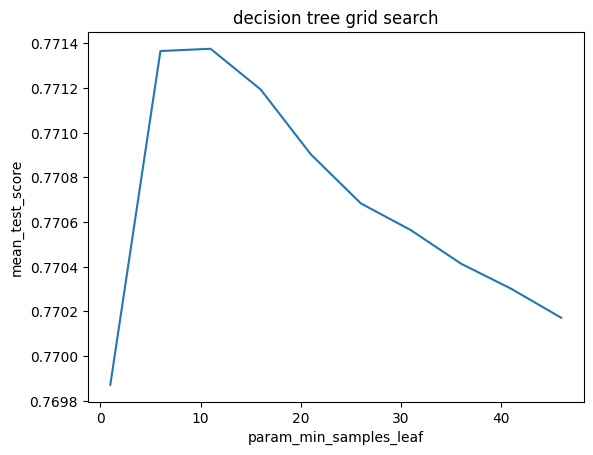

In [42]:
# plot results
# ax = sns.lineplot(data=tree_cv_res, x="param_min_samples_leaf", y = "mean_test_score", hue = "param_max_depth")
ax = sns.lineplot(data=tree_cv_res, x="param_min_samples_leaf", y = "mean_test_score")
ax.set(
    title="decision tree grid search"
)
plt.show()

In [44]:
tree_cv.best_params_

{'min_samples_leaf': 11}